<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/P6/modules/P6/module_P6_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 7.6 MB/s 


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageShow
import cv2 as cv
import sklearn

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import layers
import keras_tuner as kt


from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [4]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else: print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Download Dataset

In [5]:
# tfds.disable_progress_bar()

(train_ds, test_ds), ds_info = tfds.load(
    "stanford_dogs",
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteFYTSKQ/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteFYTSKQ/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [6]:
NO_BREEDS = ds_info.features['label'].num_classes

In [7]:
ds_info.features['label']
ds_info.features['label'].names[:20]

ClassLabel(shape=(), dtype=tf.int64, num_classes=120)

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound']

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## Dataset preprocessing

1. On applique un resizing des images afin d'avoir un dataset consistant.

> note: on peut resizer à 150 x 150, car si on garde 299 x 299 (default XCeption), la ram est tout juste suffisante sur collab, le fitting peut planter :

```
Votre session a planté après avoir utilisé toute la RAM disponible.

En tant qu'abonné Colab Pro, vous disposez de plus de mémoire, mais si vous êtes intéressé par des environnements d'exécution à mémoire RAM encore plus élevée, envisagez de passer à Colab Pro+.
```


2. On applique aussi un One Hot sur les labels

In [9]:
IMG_SIZE = 299
size = (IMG_SIZE, IMG_SIZE)


In [10]:

train_ds = train_ds\
    .map(lambda x, y: (tf.image.resize(x, size), y))\
    .map(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS))) # transform labels to one hot encoding


test_ds = test_ds\
    .map(lambda x, y: (tf.image.resize(x, size), y))\
    .map(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS))) #depth is number of classes


Cause: could not parse the source code of <function <lambda> at 0x7f0532f7cd40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f0532f7cd40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f0532f7cd40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f053327a830>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f053327a830>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f053327a830>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f0533282c20>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f0533282c20>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f0533282c20>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f0529174050>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f0529174050>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f0529174050>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS)))

Match 1:
(lambda x, y: (tf.image.resize(x, size), y))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


On applique un batching et un prefetch sur les datasets, cela va permettre de préparer et optimiser les dataset en vue de faire le fitting

In [11]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

On applique une étape de data augmentation au dataset.
En effet, on ne dispose pas de beaucoup de samples, en appliquant des transformations aléatoires on augmente le nombre de samples.

On choisi d'appliquer deux transformations:
* mirroir horizontal (inverse la droite et la gauche)
* rotation (10% à droite ou à gauche)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

Exemple d'image du dataset après data augmentation :

<Figure size 720x720 with 0 Axes>

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

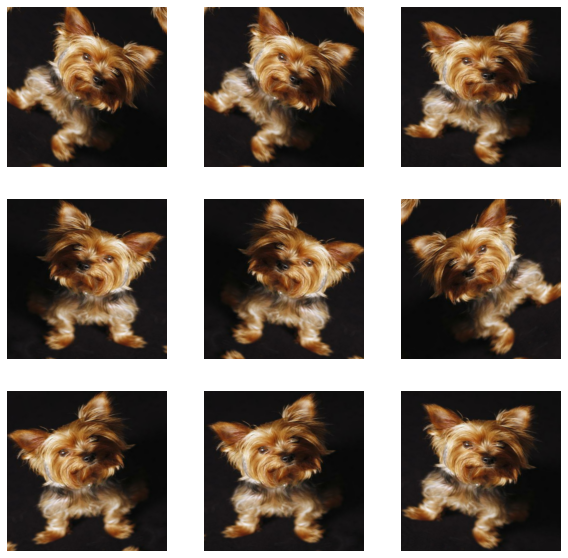

In [13]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        # plt.title(int(labels[0]))
        plt.axis("off")

In [14]:
# Function to display loss and accuracy graphs

def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

## Model from Scratch

On va créer un modèle simple, non pre-entrainé

On utilise l'api Sequential de keras

In [18]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

def compile_and_run(model, model_name: str, epochs = 20, save_model=False):
  model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
  )

  plot_model(model, show_shapes=True, show_layer_names=True, to_file=f'{model_name}.png')
  model.summary()

  callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8), # on limite le nombre d'epochs, si le loss arrette de baisser
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ProgbarLogger(count_mode="samples"),
    tf.keras.callbacks.LearningRateScheduler(scheduler) # on modifie dynamiquement le earning rate pour le diminuer au fur et à mesure des epochs
  ]

  history = model.fit(train_ds, epochs=epochs, validation_data=test_ds, callbacks=callbacks)
  plot_history_scores(history, "loss", "categorical_accuracy")
  if (save_model):
    model.save(f'{model_name}.h5')
  return history

In [43]:
#1-Conv CNN

cnn1 = Sequential()
cnn1.add(layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
cnn1.add(layers.Rescaling(1./255))
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(NO_BREEDS, activation='softmax'))

cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 flatten_2 (Flatten)         (None, 700928)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               89718912  
                                                      

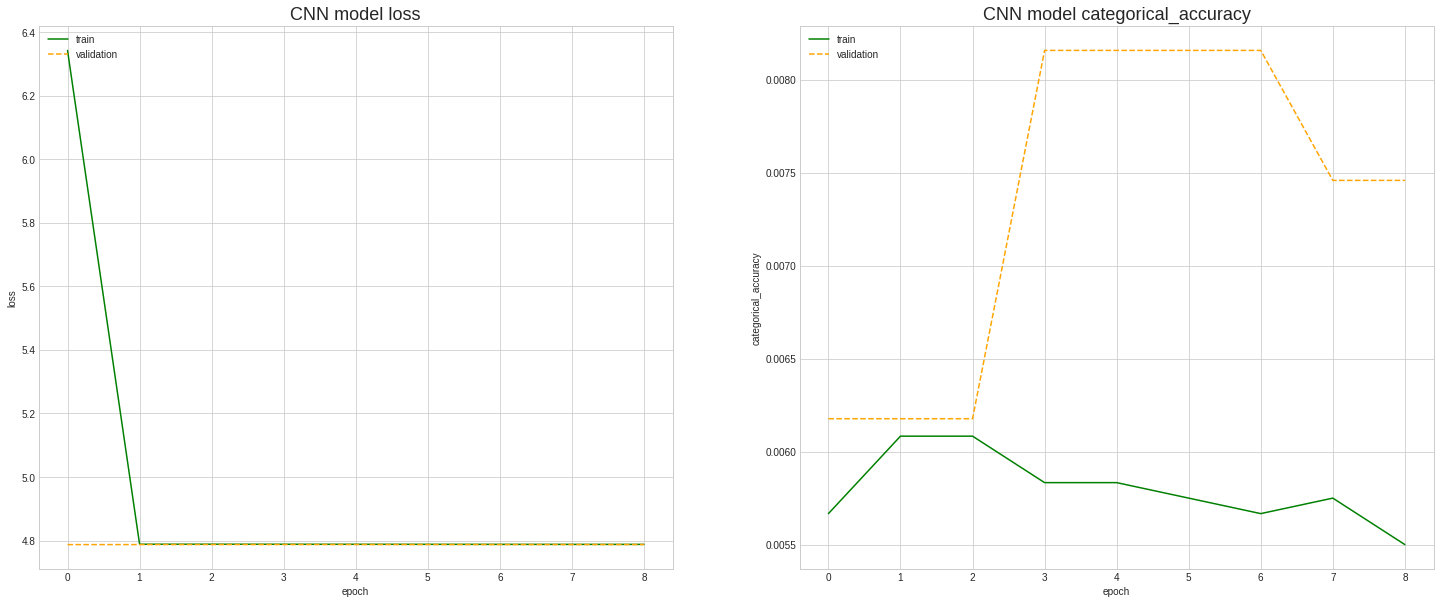

In [44]:
compile_and_run(cnn1, "cnn1", 100)

In [45]:
cnn3 = Sequential()
cnn3.add(layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
cnn3.add(layers.Rescaling(1./255))
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(NO_BREEDS, activation='softmax'))

cnn3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                  

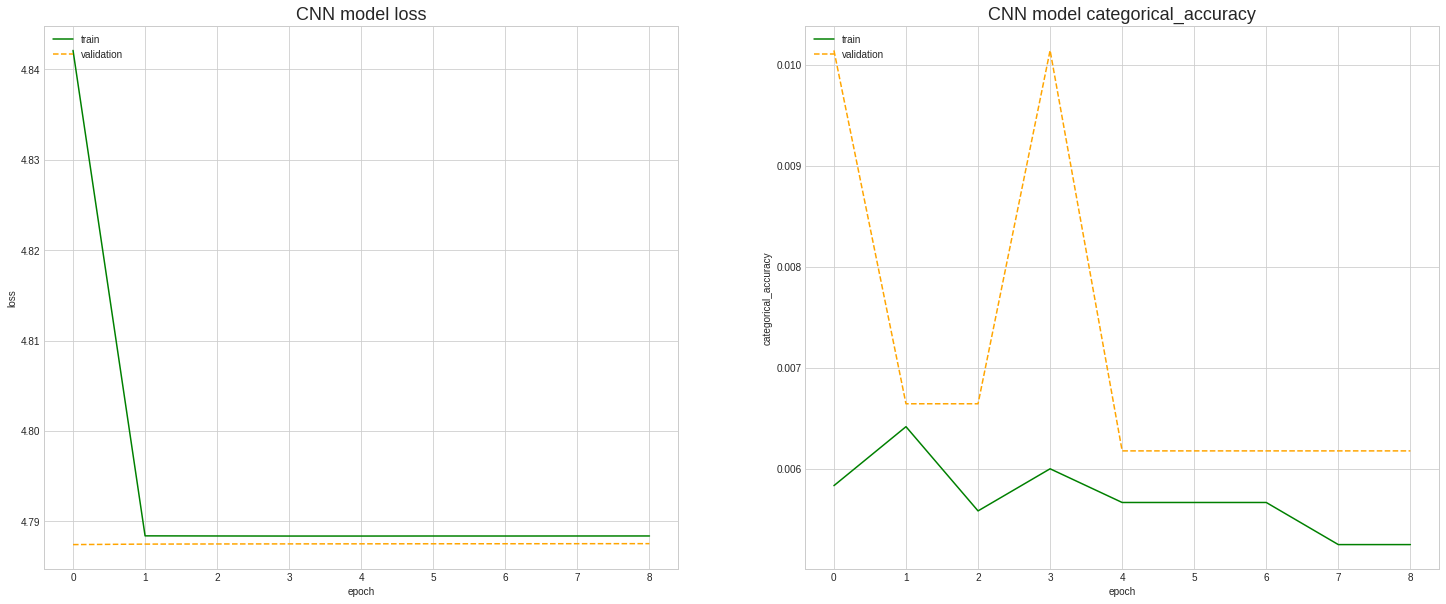

In [46]:
compile_and_run(cnn3, "cnn3", 100)

In [47]:
model_scratch = Sequential([
  layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.Rescaling(1./255),
  # Convolution layer
  layers.Conv2D(filters=16,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.Activation('relu'),

  # Pooling layer
  layers.MaxPooling2D(pool_size=(4,4),
                      strides=(4,4),
                    padding='same'),
  # Second convolution layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),   #add dropout for better performances

  # Third convolution layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.GlobalAveragePooling2D(),
  
  # Fully connected layers
  layers.Dense(128, activation='relu'),
  layers.Dense(NO_BREEDS, activation='softmax')
])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 299, 299, 16)      448       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 299, 16)     48        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 299, 299, 16)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 75, 75, 32)       

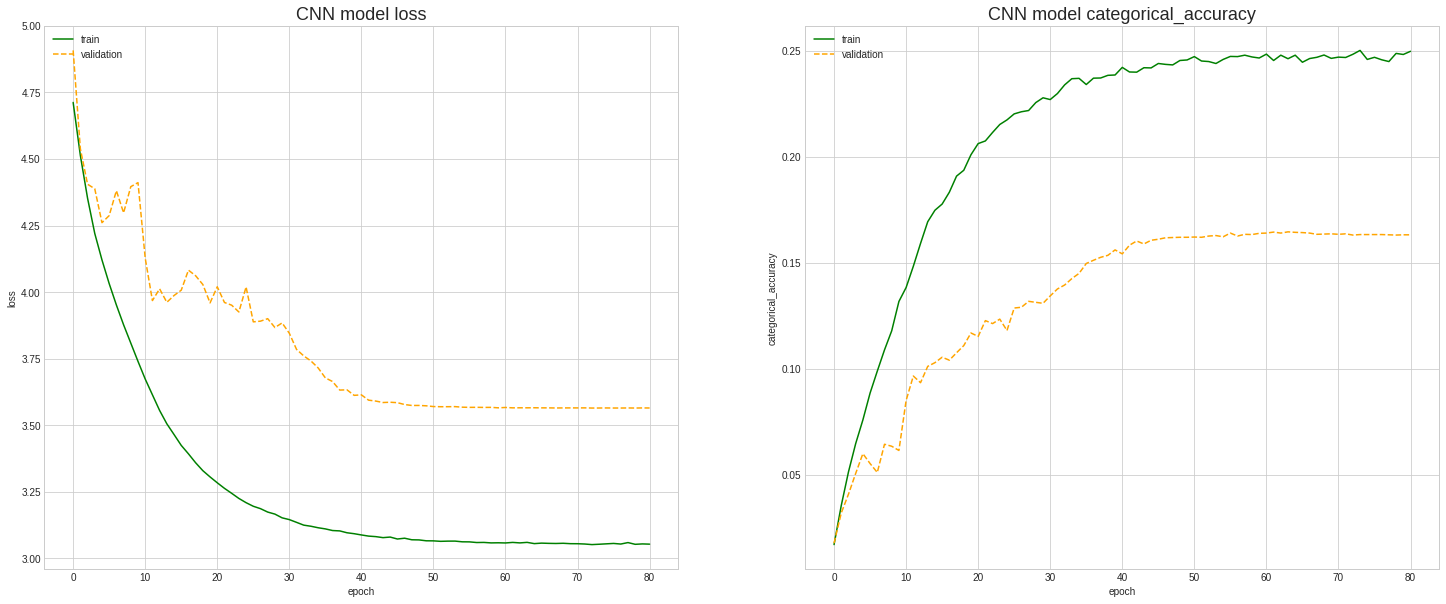

In [48]:
compile_and_run(model_scratch, "model_scratch", 100)

On constate que le modele, passé 20 epoch, n'apprends plus car le validation loss ne baisse pas, voire augmente, tandis que le training loss continue de baisser.

Cela traduit que le modèle est en overfitting. Il faut ajouter de la rergularisation

In [49]:
model_scratch = Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#   layers.Resizing(IMG_SIZE, IMG_SIZE, crop_to_aspect_ratio=True),
  layers.Rescaling(1./255),
#   layers.Reshape((IMG_SIZE, IMG_SIZE, 3)),
  
  # Convolution layer
  layers.Conv2D(filters=16,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.Activation('relu'),

  # Pooling layer
  layers.MaxPooling2D(pool_size=(4,4),
                      strides=(4,4),
                    padding='same'),
  # Second convolution layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),   #add dropout for better performances

  # Third convolution layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.GlobalAveragePooling2D(),
  
  # Fully connected layers
  layers.Dense(128, activation='relu'),
  layers.Dense(NO_BREEDS, activation='softmax')
])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 299, 299, 16)      448       
                                                                 
 batch_normalization_9 (Batc  (None, 299, 299, 16)     48        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 299, 299, 16)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 75, 32)       

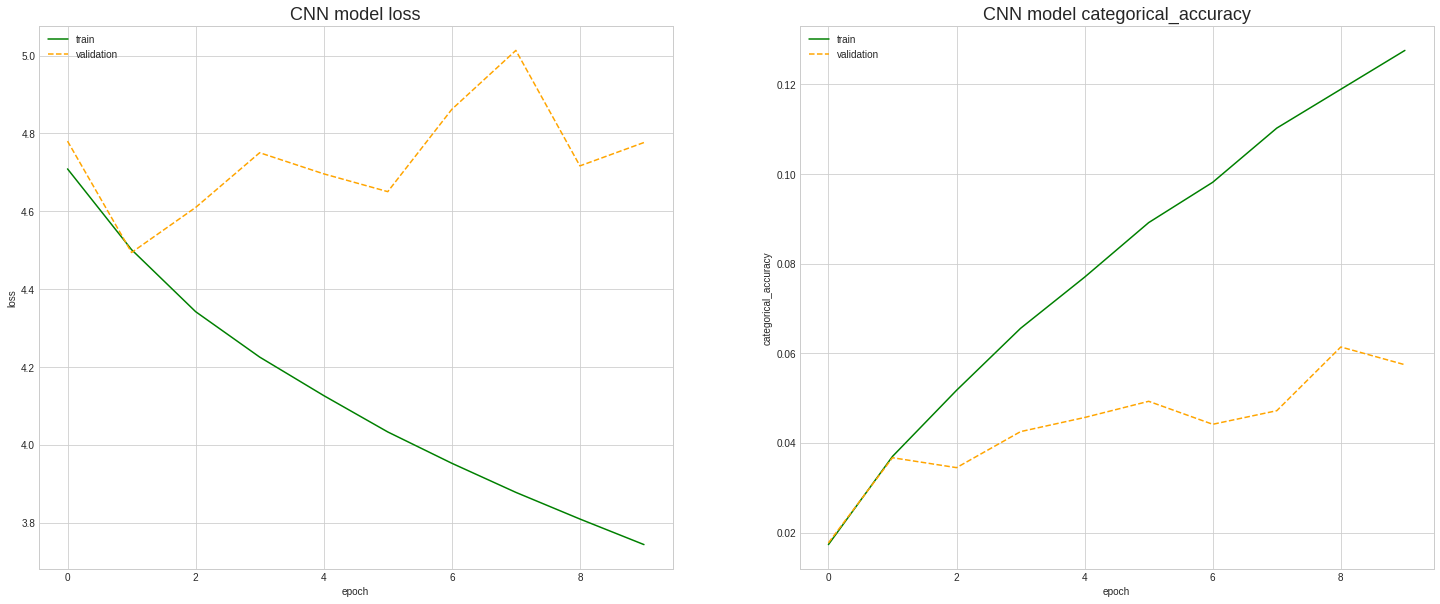

In [50]:
compile_and_run(model_scratch, "model_scratch", 100)

On voit qu'après 600 epochs, qui représente + 3h de compute, accuracy continue de progresser. Mais on est clairement dans de l'overfitting, car le validation loss continue de progresser, alors que le training loss continue de baisse.

Par contre on risquerait de faire de l'over fitting. Pour éviter cela, en plus de la couche de dropout, et de la data augmentation, on peut ajouter de la regularisation.


explication tensorflow: <https://www.tensorflow.org/tutorials/keras/overfit_and_underfit>

explication underfitting / overfitting : <https://www.baeldung.com/cs/training-validation-loss-deep-learning>




In [ ]:
history_scratch.model.save('scratch_trained_model.h5')

## Xception model

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(NO_BREEDS, activation='softmax')(x)  #120 = number of breeds
model = keras.Model(inputs, outputs)

Train top layer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

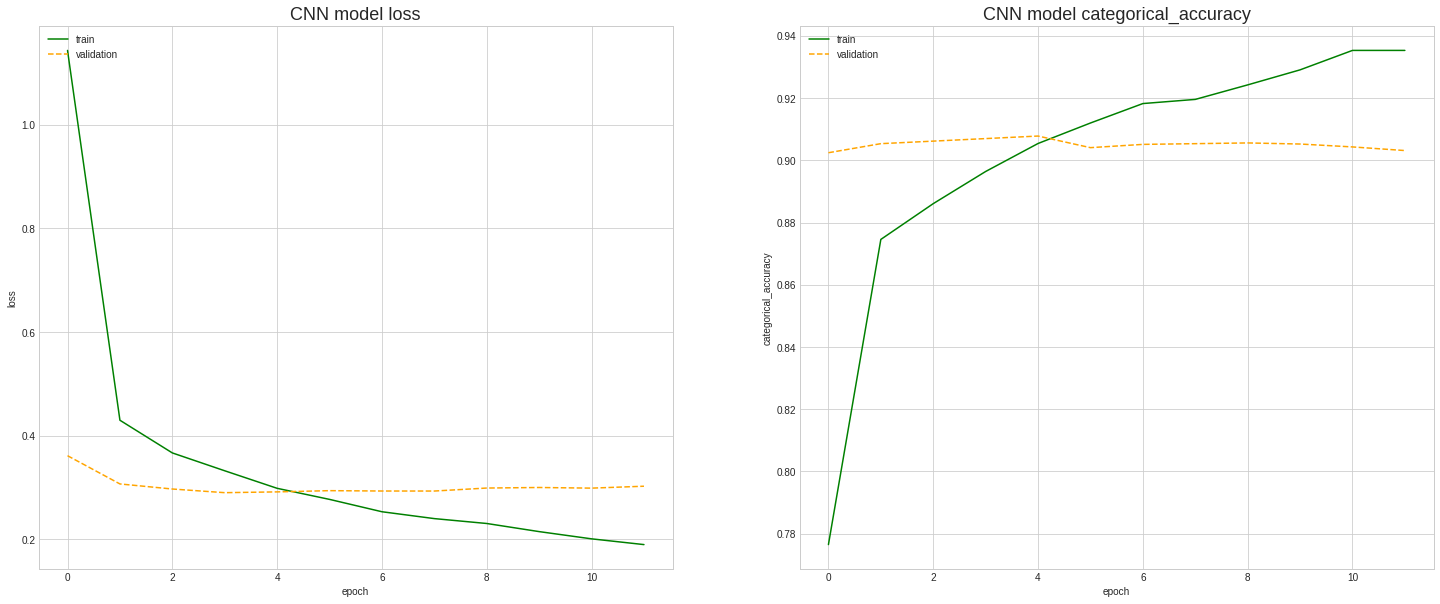

In [19]:
compile_and_run(model, "xception_trained_model", epochs=25, save_model=True)

Estimation rapide

In [20]:
for images, labels in test_ds.take(2):
    for i in range(labels.shape[0] -1):
        label_id = np.argmax(labels[i])
        label_name = ds_info.features['label'].names[label_id]
        found_label_id = np.argmax(model(images, training=False)[i], axis=0)
        found_label = ds_info.features['label'].names[found_label_id]
        if (label_id == found_label_id):
            found = 'ok !'
        else:
            found = ':('
        print(f'given: {label_name} --> found: {found_label} -- {found}')


given: n02102177-welsh_springer_spaniel --> found: n02102177-welsh_springer_spaniel -- ok !
given: n02106662-german_shepherd --> found: n02106662-german_shepherd -- ok !
given: n02099712-labrador_retriever --> found: n02099712-labrador_retriever -- ok !
given: n02088466-bloodhound --> found: n02088466-bloodhound -- ok !
given: n02107683-bernese_mountain_dog --> found: n02107683-bernese_mountain_dog -- ok !
given: n02093859-kerry_blue_terrier --> found: n02093859-kerry_blue_terrier -- ok !
given: n02099429-curly-coated_retriever --> found: n02099429-curly-coated_retriever -- ok !
given: n02088094-afghan_hound --> found: n02088094-afghan_hound -- ok !
given: n02102318-cocker_spaniel --> found: n02102318-cocker_spaniel -- ok !
given: n02110185-siberian_husky --> found: n02110185-siberian_husky -- ok !
given: n02088238-basset --> found: n02088238-basset -- ok !
given: n02085782-japanese_spaniel --> found: n02085782-japanese_spaniel -- ok !
given: n02100583-vizsla --> found: n02100583-vizsl

Certaines prédictions sont fausses, en regardant des exemples de races, on constate qu'elles sont très proches ce qui peut induire le modèle en erreur.

Le modèle a confondu ces races :

coated_wheaten_terrier avec sealyham_terrier : 
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/coated_wheaten_terrier.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/sealyham_terrier.jpg?raw=1)

airedale avec lakeland_terrier:
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/airedale.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/lakeland_terrier.jpg?raw=1)

standard_poodle avec miniature_poodle
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/standard_poodle.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/miniature_poodle.jpg?raw=1)

norwegian_elkhound avec leonberg
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/norwegian_elkhound.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/leonberg.jpg?raw=1)

Il pourrait être difficile pour quelqu'un de non avisé de faire la différence.

## APPENDIX & Docs

### Data augmentation:

<https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/>


### Model compile

What are the choices for optimizer, loss & metrics ? : <https://keras.io/guides/training_with_built_in_methods#many-builtin-optimizers-losses-and-metrics-are-available>

* optimizers: <https://keras.io/api/optimizers/>
* Losses: <https://keras.io/api/losses/>
* Metrics: <https://keras.io/api/metrics/>



tip: in order to view GPU usage, type command: `watch -n 1 nvidia-smi`

### Pre-trained model : Transfer Learning

Kera doc: <https://keras.io/guides/transfer_learning/>

deep learning with Python <https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html>

